In [1]:
import os
os.chdir('../..')

In [2]:
from platform import python_version

print(python_version())

3.7.9


In [218]:
import numpy as np
import pandas as pd
import json
import random
import warnings
from sklearn.exceptions import ConvergenceWarning

import tensorflow as tf
from modules.datgan import DATWGAN

import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture

from modules.datgan.utils import get_persistent_homology

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [261]:
df = pd.read_csv('../data/LPMC/data.csv')

In [281]:
data = df['driving_traffic_percent'].values.reshape([-1, 1])

In [282]:
data

array([[0.111702],
       [0.11215 ],
       [0.203052],
       ...,
       [0.234568],
       [0.760832],
       [0.652995]])

In [284]:
idx = np.random.choice(len(data), 10000)

In [285]:
idx

array([62439, 20914, 57909, ..., 19478, 75410, 23336])

In [286]:
samples = data[idx]

In [287]:
samples

array([[0.21037  ],
       [0.350877 ],
       [0.807847 ],
       ...,
       [0.0334129],
       [0.260116 ],
       [0.713634 ]])

In [278]:
n_modes = 10

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

print("  Fitting model with {:d} components".format(n_modes))

while True:
    
    # Fit the BGM
    model = BayesianGaussianMixture(
        n_components=n_modes,
        max_iter=200,
        n_init=10,
        init_params='kmeans',
        weight_concentration_prior_type='dirichlet_process')
    
    samples = np.random.choice(data, 10000)
    
    model.fit(samples.reshape([-1, 1]))

    # Check that BGM is using all the classes!
    pred_ = np.unique(model.predict(samples.reshape([-1, 1])))
    
    # Check that the weights are large enough
    w = model.weights_ > 1e-2
    
    # Choose what to do
    if len(pred_) != n_modes:
        n_modes = len(pred_)
        print("  Predictions were done on {:d} components => Fit with {:d} components!".format(n_modes, n_modes))
    elif np.sum(w) != n_modes:
        n_modes = np.sum(w)
        print("  Some weights are too small =>  => Fit with {:d} components!".format(n_modes))
    else:
        print("  Predictions were done on {:d} components => FINISHED!".format(n_modes))
        break
        
#print("  Train VGM with full data")
#model.fit(data.reshape([-1, 1]))

  Fitting model with 10 components
  Predictions were done on 8 components => Fit with 8 components!
  Predictions were done on 6 components => Fit with 6 components!
  Predictions were done on 6 components => FINISHED!


Text(0, 0.5, '$p(x)$')

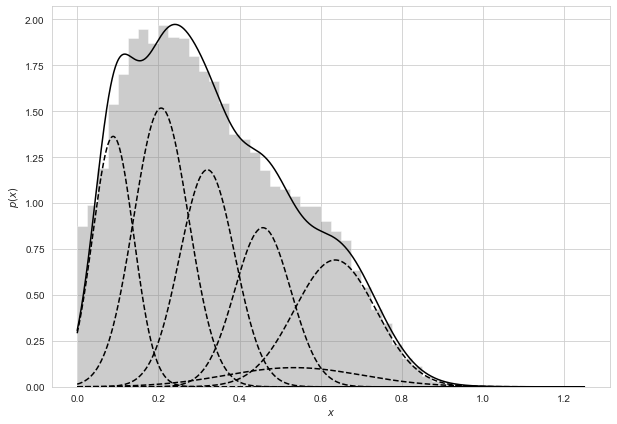

In [279]:
fig = plt.figure(figsize=(10, 7))
plt.hist(data, 50, density=True, histtype='stepfilled', alpha=0.4, color='gray')

x = np.linspace(np.min(data), np.max(data), 1000)

logprob = model.score_samples(x.reshape(-1, 1))
responsibilities = model.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
plt.plot(x, pdf, '-k')
plt.plot(x, pdf_individual, '--k')

plt.xlabel('$x$')
plt.ylabel('$p(x)$')